# Construal shifting Experiment 2

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(pwr)
library(lme4)
library(lmerTest)
library(lmtest)
library(scales)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [4]:
def save_paper_input(input_name, input_str):
    filename = f"./inputs/{input_name}.tex"
    with open(filename, 'w') as file:
        file.write(input_str)
    print(f"Saved to {filename}:\n{input_str}")
    
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [5]:
import matplotlib
font = {
    'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 12
}

matplotlib.rc('font', **font)

In [6]:
import json
import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from msdm.algorithms import PolicyIteration
from msdm.core.distributions import SoftmaxDistribution

from construal_shifting.fastgridworld import GridWorld2 as GridWorld
from construal_shifting.utils import maze_code
from construal_shifting.construal import construal_level, construal_utility, construal_size, calculate_construal_dist, maze_construals
from construal_shifting import gridutils, sampsat

In [7]:
summary_df = pd.read_json('./data/summary_df.json')
test_trials = pd.read_json('./data/test_trial_stats.json')

In [8]:
save_paper_input(f"exp2_n_participants", str(len(summary_df)))

Saved to ./inputs/exp2_n_participants.tex:
294


In [9]:
test_trials['grid_idx'] = test_trials.grid_name.apply(lambda g: int(g.split('-')[0]))
test_trials['visited_notch'] = test_trials['notch_occupancy'] > 0
test_trials['log_initial_rt_milliseconds'] = np.log(test_trials['initial_rt_milliseconds'])
test_trials_summary = pd.merge(
    test_trials.groupby(['sessionId', 'condition_name'])[[
        'initial_rt_milliseconds',
        'log_initial_rt_milliseconds',
        'timesteps',
        'total_reward',
        'notch_occupancy'
    ]].mean(),
    test_trials.groupby(['sessionId', 'condition_name'])[[
        'visited_notch',
        'visited_critical_notch',
    ]].sum(),
    on=['sessionId', 'condition_name']
).reset_index()

In [10]:
test_trials_summary.groupby(['condition_name'])[
    ['visited_critical_notch', 'visited_notch', 'log_initial_rt_milliseconds', 'total_reward']
        
].agg(['mean', 'sem', 'count'])

visited_critical_notch                 visited_notch  \
                                        mean       sem count          mean   
condition_name                                                               
ffffffffffff_bbbbbbbb               1.942857  0.153607   105      2.171429   
ffffffffffff_cccccccc               0.041667  0.020502    96      0.156250   
ffffffffffff_ffffffff               7.064516  0.163818    93      7.075269   

                                      log_initial_rt_milliseconds            \
                            sem count                        mean       sem   
condition_name                                                                
ffffffffffff_bbbbbbbb  0.164894   105                    7.718434  0.062509   
ffffffffffff_cccccccc  0.042736    96                    7.499082  0.064679   
ffffffffffff_ffffffff  0.163411    93                    7.964710  0.064962   

                            total_reward                  
                      count         mean       sem count  
condition_name                                            
ffffffffffff_bbbbbbbb   105   -29.502381  0.601385   105  
ffffffffffff_cccccccc    96   -29.140625  0.611104    96  
ffffffffffff_ffffffff    93   -31.552419  0.810772    93

In [11]:
test_trials_fc = test_trials[test_trials.condition_name.isin(['ffffffffffff_ffffffff', 'ffffffffffff_cccccccc'])]
test_trials_fb = test_trials[test_trials.condition_name.isin(['ffffffffffff_ffffffff', 'ffffffffffff_bbbbbbbb'])]
test_trials_cb = test_trials[test_trials.condition_name.isin(['ffffffffffff_cccccccc', 'ffffffffffff_bbbbbbbb'])]

### Analysis of critical notch visitation

In [12]:
%%R -i test_trials_fc,test_trials_fb,test_trials_cb
# sum code with fine-grained test as +.5

test_trials_fc$condition_name <- factor(
    test_trials_fc$condition_name,
    levels=c('ffffffffffff_ffffffff', 'ffffffffffff_cccccccc')
)
contrasts(test_trials_fc$condition_name) <- contr.sum(2)*.5
print(contrasts(test_trials_fc$condition_name))

test_trials_fb$condition_name <- factor(
    test_trials_fb$condition_name,
    levels=c('ffffffffffff_ffffffff', 'ffffffffffff_bbbbbbbb')
)
contrasts(test_trials_fb$condition_name) <- contr.sum(2)*.5
print(contrasts(test_trials_fb$condition_name))

test_trials_cb$condition_name <- factor(
    test_trials_cb$condition_name,
    levels=c('ffffffffffff_bbbbbbbb', 'ffffffffffff_cccccccc')
)
contrasts(test_trials_cb$condition_name) <- contr.sum(2)*.5
print(contrasts(test_trials_cb$condition_name))


                      [,1]
ffffffffffff_ffffffff  0.5
ffffffffffff_cccccccc -0.5
                      [,1]
ffffffffffff_ffffffff  0.5
ffffffffffff_bbbbbbbb -0.5
                      [,1]
ffffffffffff_bbbbbbbb  0.5
ffffffffffff_cccccccc -0.5


In [13]:
%%R -o model_comp_crit_notch_fc,full_mod_fc_summary
base_mod <- glm(
    visited_critical_notch ~ 1,
    data=test_trials_fc,
    family=binomial
)
model_comp_crit_notch_fc <- anova(
    base_mod,
    update(base_mod, . ~ + condition_name),
    # update(base_mod, . ~ + condition_name + test_trial_num),
    # update(base_mod, . ~ + condition_name*test_trial_num),
    test='LRT'
)

full_mod_fc <- update(base_mod, . ~ + condition_name)
full_mod_fc_summary <- summary(full_mod_fc)$coeff
# print(summary(full_mod_fc))
# print(model_comp_crit_notch_fc)

In [14]:
model_comp_crit_notch_fc_summary = (
    lambda r: f"$\chi^{2}({r['Df']:.0f}) = {r['Deviance']:.2f}, p = {latex_float(r['Pr(>Chi)'])}$"
)(model_comp_crit_notch_fc.loc['2'])
model_comp_crit_notch_fc_summary = model_comp_crit_notch_fc_summary.replace("p = 0", "p < 2.0 \\times 10^{-16}")
save_paper_input(f"exp2_condition_crit_notch_fc_chisq_test", model_comp_crit_notch_fc_summary)

Saved to ./inputs/exp2_condition_crit_notch_fc_chisq_test.tex:
$\chi^2(1) = 1485.27, p < 2.0 \times 10^{-16}$


In [15]:
full_mod_fc_summary_df = pd.DataFrame(
    index=["Intercept", "Condition"],
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(>|z|)'],
    data=full_mod_fc_summary
)
full_mod_fc_summary_df['summary'] = full_mod_fc_summary_df.apply(
    lambda r: f"$\\beta = {r['Estimate']:.2f}$, S.E. $= {r['Std. Error']:.2f}$",
    axis=1
)
for idx, row in full_mod_fc_summary_df.iterrows():
    if idx == "Intercept":
        continue
    save_paper_input(f"exp2_{idx}_crit_notch_reg_est_fc", row['summary'])

Saved to ./inputs/exp2_Condition_crit_notch_reg_est_fc.tex:
$\beta = 7.27$, S.E. $= 0.51$


In [16]:
%%R -o model_comp_crit_notch_fb,full_mod_fb_summary
base_mod <- glm(
    visited_critical_notch ~ 1,
    data=test_trials_fb,
    family=binomial
)
model_comp_crit_notch_fb <- anova(
    base_mod,
    update(base_mod, . ~ + condition_name),
    test='LRT'
)
full_mod_fb <- update(base_mod, . ~ + condition_name)
full_mod_fb_summary <- summary(full_mod_fb)$coeff
# print(summary(full_mod_fb))
# print(model_comp_crit_notch_fb)

In [17]:
model_comp_crit_notch_fb_summary = (
    lambda r: f"$\chi^{2}({r['Df']:.0f}) = {r['Deviance']:.2f}, p = {latex_float(r['Pr(>Chi)'])}$"
)(model_comp_crit_notch_fb.loc['2'])
model_comp_crit_notch_fb_summary = model_comp_crit_notch_fb_summary.replace("p = 0", "p < 2.0 \\times 10^{-16}")
save_paper_input(f"exp2_condition_crit_notch_fb_chisq_test", model_comp_crit_notch_fb_summary)

Saved to ./inputs/exp2_condition_crit_notch_fb_chisq_test.tex:
$\chi^2(1) = 715.71, p = 1.1 \times 10^{-157}$


In [18]:
full_mod_fb_summary_df = pd.DataFrame(
    index=["Intercept", "Condition"],
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(>|z|)'],
    data=full_mod_fb_summary
)
full_mod_fb_summary_df['summary'] = full_mod_fb_summary_df.apply(
    lambda r: f"$\\beta = {r['Estimate']:.2f}$, S.E. $= {r['Std. Error']:.2f}$",
    axis=1
)
for idx, row in full_mod_fb_summary_df.iterrows():
    if idx == "Intercept":
        continue
    save_paper_input(f"exp2_{idx}_crit_notch_reg_est_fb", row['summary'])

Saved to ./inputs/exp2_Condition_crit_notch_reg_est_fb.tex:
$\beta = 3.16$, S.E. $= 0.14$


In [19]:
%%R -o model_comp_crit_notch_cb,full_mod_cb_summary
base_mod <- glm(
    visited_critical_notch ~ 1,
    data=test_trials_cb,
    family=binomial
)
model_comp_crit_notch_cb <- anova(
    base_mod,
    update(base_mod, . ~ + condition_name),
    test='LRT'
)
full_mod_cb <- update(base_mod, . ~ + condition_name)
full_mod_cb_summary <- summary(full_mod_cb)$coeff

In [20]:
model_comp_crit_notch_cb_summary = (
    lambda r: f"$\chi^{2}({r['Df']:.0f}) = {r['Deviance']:.2f}, p = {latex_float(r['Pr(>Chi)'])}$"
)(model_comp_crit_notch_cb.loc['2'])
model_comp_crit_notch_cb_summary = model_comp_crit_notch_cb_summary.replace("p = 0", "p < 2.0 \\times 10^{-16}")
save_paper_input(f"exp2_condition_crit_notch_cb_chisq_test", model_comp_crit_notch_cb_summary)

Saved to ./inputs/exp2_condition_crit_notch_cb_chisq_test.tex:
$\chi^2(1) = 257.31, p = 6.6 \times 10^{-58}$


In [21]:
full_mod_cb_summary_df = pd.DataFrame(
    index=["Intercept", "Condition"],
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(>|z|)'],
    data=full_mod_cb_summary
)
full_mod_cb_summary_df['summary'] = full_mod_cb_summary_df.apply(
    lambda r: f"$\\beta = {r['Estimate']:.2f}$, S.E. $= {r['Std. Error']:.2f}$",
    axis=1
)
for idx, row in full_mod_cb_summary_df.iterrows():
    if idx == "Intercept":
        continue
    save_paper_input(f"exp2_{idx}_crit_notch_reg_est_cb", row['summary'])

Saved to ./inputs/exp2_Condition_crit_notch_reg_est_cb.tex:
$\beta = 4.12$, S.E. $= 0.51$


### Analysis of reaction times

In [22]:
%%R -o log_init_rt_summary_coeff_fc,log_init_rt_model_comp_fc
base_mod <- lm(
    log_initial_rt_milliseconds ~ 1,
    data=test_trials_fc,
)
log_init_rt_model_comp_fc <- lrtest(
    base_mod,
    update(base_mod, . ~ . + condition_name),
    update(base_mod, . ~ . + condition_name + test_trial_num)
)
log_init_rt_summary_coeff_fc <- summary(update(base_mod, . ~ . + condition_name + test_trial_num))$coeff

In [23]:
log_init_rt_model_comp_fc['model'] = [
    "base",
    "condition",
    "condition_trial"
]
log_init_rt_model_comp_fc = log_init_rt_model_comp_fc[
    log_init_rt_model_comp_fc['model'].isin(["condition", "condition_trial"])
]
log_init_rt_model_comp_fc["summary"] = log_init_rt_model_comp_fc.apply(
    lambda r: f"$\chi^{2}({r['Df']:.0f}) = {r['Chisq']:.2f}, p = {latex_float(r['Pr(>Chisq)'])}$",
    axis=1
)
for _, row in log_init_rt_model_comp_fc.iterrows():
    if row['model'] == 'base':
        continue
    save_paper_input(f"exp2_{row['model']}_init_rt_chisq_test_fc", row['summary'])

Saved to ./inputs/exp2_condition_init_rt_chisq_test_fc.tex:
$\chi^2(1) = 139.24, p = 3.9 \times 10^{-32}$
Saved to ./inputs/exp2_condition_trial_init_rt_chisq_test_fc.tex:
$\chi^2(1) = 21.24, p = 4 \times 10^{-6}$


In [24]:
log_init_rt_summary_coeff_fc_df = pd.DataFrame(
    index=["intercept", "condition", "trial"],
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(>|z|)'],
    data=log_init_rt_summary_coeff_fc
)
log_init_rt_summary_coeff_fc_df['summary'] = log_init_rt_summary_coeff_fc_df.apply(
    lambda r: f"$\\beta = {r['Estimate']:.2f}$, S.E. $= {r['Std. Error']:.2f}$",
    axis=1
)
for idx, row in log_init_rt_summary_coeff_fc_df.iterrows():
    if idx == 'intercept':
        continue
    save_paper_input(f"exp2_{idx}_init_rt_reg_est_fc", row['summary'])

Saved to ./inputs/exp2_condition_init_rt_reg_est_fc.tex:
$\beta = 0.47$, S.E. $= 0.04$
Saved to ./inputs/exp2_trial_init_rt_reg_est_fc.tex:
$\beta = -0.04$, S.E. $= 0.01$


In [25]:
%%R -o log_init_rt_summary_coeff_fb,log_init_rt_model_comp_fb
base_mod <- lm(
    log_initial_rt_milliseconds ~ 1,
    data=test_trials_fb,
)
log_init_rt_model_comp_fb <- lrtest(
    base_mod,
    update(base_mod, . ~ . + condition_name),
    update(base_mod, . ~ . + condition_name + test_trial_num)
)
log_init_rt_summary_coeff_fb <- summary(update(base_mod, . ~ . + condition_name + test_trial_num))$coeff

In [26]:
log_init_rt_model_comp_fb['model'] = [
    "base",
    "condition",
    "condition_trial"
]
log_init_rt_model_comp_fb = log_init_rt_model_comp_fb[
    log_init_rt_model_comp_fb['model'].isin(["condition", "condition_trial"])
]
log_init_rt_model_comp_fb["summary"] = log_init_rt_model_comp_fb.apply(
    lambda r: f"$\chi^{2}({r['Df']:.0f}) = {r['Chisq']:.2f}, p = {latex_float(r['Pr(>Chisq)'])}$",
    axis=1
)
for _, row in log_init_rt_model_comp_fb.iterrows():
    if row['model'] == 'base':
        continue
    save_paper_input(f"exp2_{row['model']}_init_rt_chisq_test_fb", row['summary'])

Saved to ./inputs/exp2_condition_init_rt_chisq_test_fb.tex:
$\chi^2(1) = 42.96, p = 5.6 \times 10^{-11}$
Saved to ./inputs/exp2_condition_trial_init_rt_chisq_test_fb.tex:
$\chi^2(1) = 8.78, p = 0.003$


In [27]:
log_init_rt_summary_coeff_fb_df = pd.DataFrame(
    index=["intercept", "condition", "trial"],
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(>|z|)'],
    data=log_init_rt_summary_coeff_fb
)
log_init_rt_summary_coeff_fb_df['summary'] = log_init_rt_summary_coeff_fb_df.apply(
    lambda r: f"$\\beta = {r['Estimate']:.2f}$, S.E. $= {r['Std. Error']:.2f}$",
    axis=1
)
for idx, row in log_init_rt_summary_coeff_fb_df.iterrows():
    if idx == 'intercept':
        continue
    save_paper_input(f"exp2_{idx}_init_rt_reg_est_fb", row['summary'])

Saved to ./inputs/exp2_condition_init_rt_reg_est_fb.tex:
$\beta = 0.25$, S.E. $= 0.04$
Saved to ./inputs/exp2_trial_init_rt_reg_est_fb.tex:
$\beta = -0.02$, S.E. $= 0.01$


In [28]:
%%R -o log_init_rt_summary_coeff_cb,log_init_rt_model_comp_cb
base_mod <- lm(
    log_initial_rt_milliseconds ~ 1,
    data=test_trials_cb,
)
log_init_rt_model_comp_cb <- lrtest(
    base_mod,
    update(base_mod, . ~ . + condition_name),
    update(base_mod, . ~ . + condition_name + test_trial_num)
)
log_init_rt_summary_coeff_cb <- summary(update(base_mod, . ~ . + condition_name + test_trial_num))$coeff

In [29]:
log_init_rt_model_comp_cb['model'] = [
    "base",
    "condition",
    "condition_trial"
]
log_init_rt_model_comp_cb = log_init_rt_model_comp_cb[
    log_init_rt_model_comp_cb['model'].isin(["condition", "condition_trial"])
]
log_init_rt_model_comp_cb["summary"] = log_init_rt_model_comp_cb.apply(
    lambda r: f"$\chi^{2}({r['Df']:.0f}) = {r['Chisq']:.2f}, p = {latex_float(r['Pr(>Chisq)'])}$",
    axis=1
)
for _, row in log_init_rt_model_comp_cb.iterrows():
    if row['model'] == 'base':
        continue
    save_paper_input(f"exp2_{row['model']}_init_rt_chisq_test_cb", row['summary'])

Saved to ./inputs/exp2_condition_init_rt_chisq_test_cb.tex:
$\chi^2(1) = 34.00, p = 5.5 \times 10^{-9}$
Saved to ./inputs/exp2_condition_trial_init_rt_chisq_test_cb.tex:
$\chi^2(1) = 31.66, p = 1.8 \times 10^{-8}$


In [30]:
log_init_rt_summary_coeff_cb_df = pd.DataFrame(
    index=["intercept", "condition", "trial"],
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(>|z|)'],
    data=log_init_rt_summary_coeff_cb
)
log_init_rt_summary_coeff_cb_df['summary'] = log_init_rt_summary_coeff_cb_df.apply(
    lambda r: f"$\\beta = {r['Estimate']:.2f}$, S.E. $= {r['Std. Error']:.2f}$",
    axis=1
)
for idx, row in log_init_rt_summary_coeff_cb_df.iterrows():
    if idx == 'intercept':
        continue
    save_paper_input(f"exp2_{idx}_init_rt_reg_est_cb", row['summary'])

Saved to ./inputs/exp2_condition_init_rt_reg_est_cb.tex:
$\beta = 0.22$, S.E. $= 0.04$
Saved to ./inputs/exp2_trial_init_rt_reg_est_cb.tex:
$\beta = -0.05$, S.E. $= 0.01$


# Figures

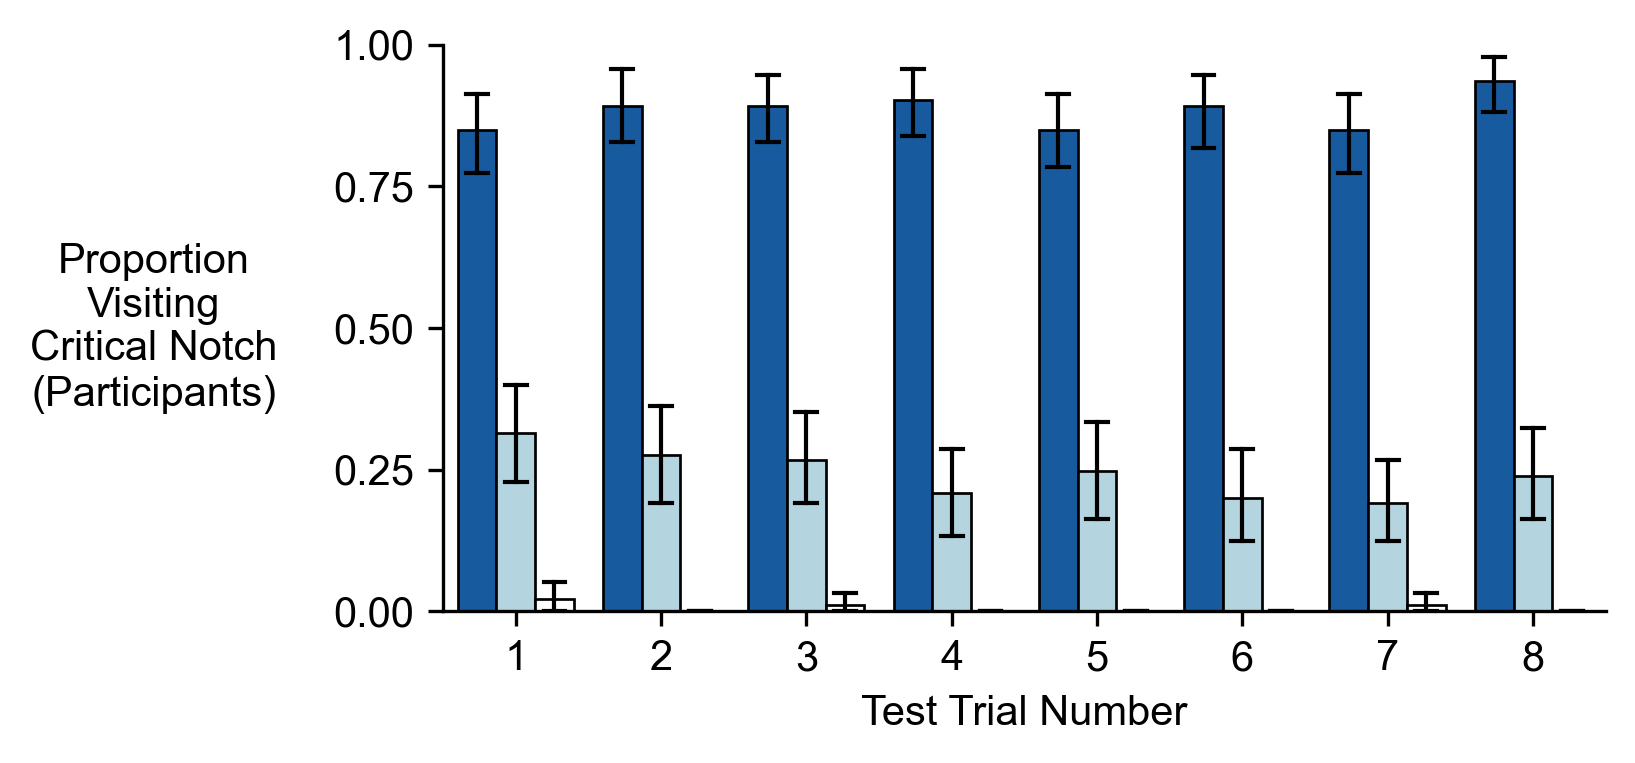

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5), dpi=300)
g = sns.barplot(
    ax=ax,
    data=test_trials,
    x='test_trial_num',
    y='visited_critical_notch',
    hue='condition_name',
    hue_order=['ffffffffffff_ffffffff', 'ffffffffffff_bbbbbbbb', 'ffffffffffff_cccccccc'],
    palette=["#005AB5", "lightblue", "w"],
    edgecolor='k',
    linewidth=.65,
    errwidth=1.,
    capsize=.15,
    errcolor='k',
)
g.set_ylim(0, 1.0)
g.set_yticks([0, .25, .5, .75, 1.0])
g.legend_.remove()
ax.set_ylabel("Proportion\nVisiting\nCritical Notch\n(Participants)", rotation="horizontal", labelpad=43, va='center')
ax.set_xlabel("Test Trial Number")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = ax.set_xticklabels(["1", "2", "3", "4", "5", '6', '7', '8'])

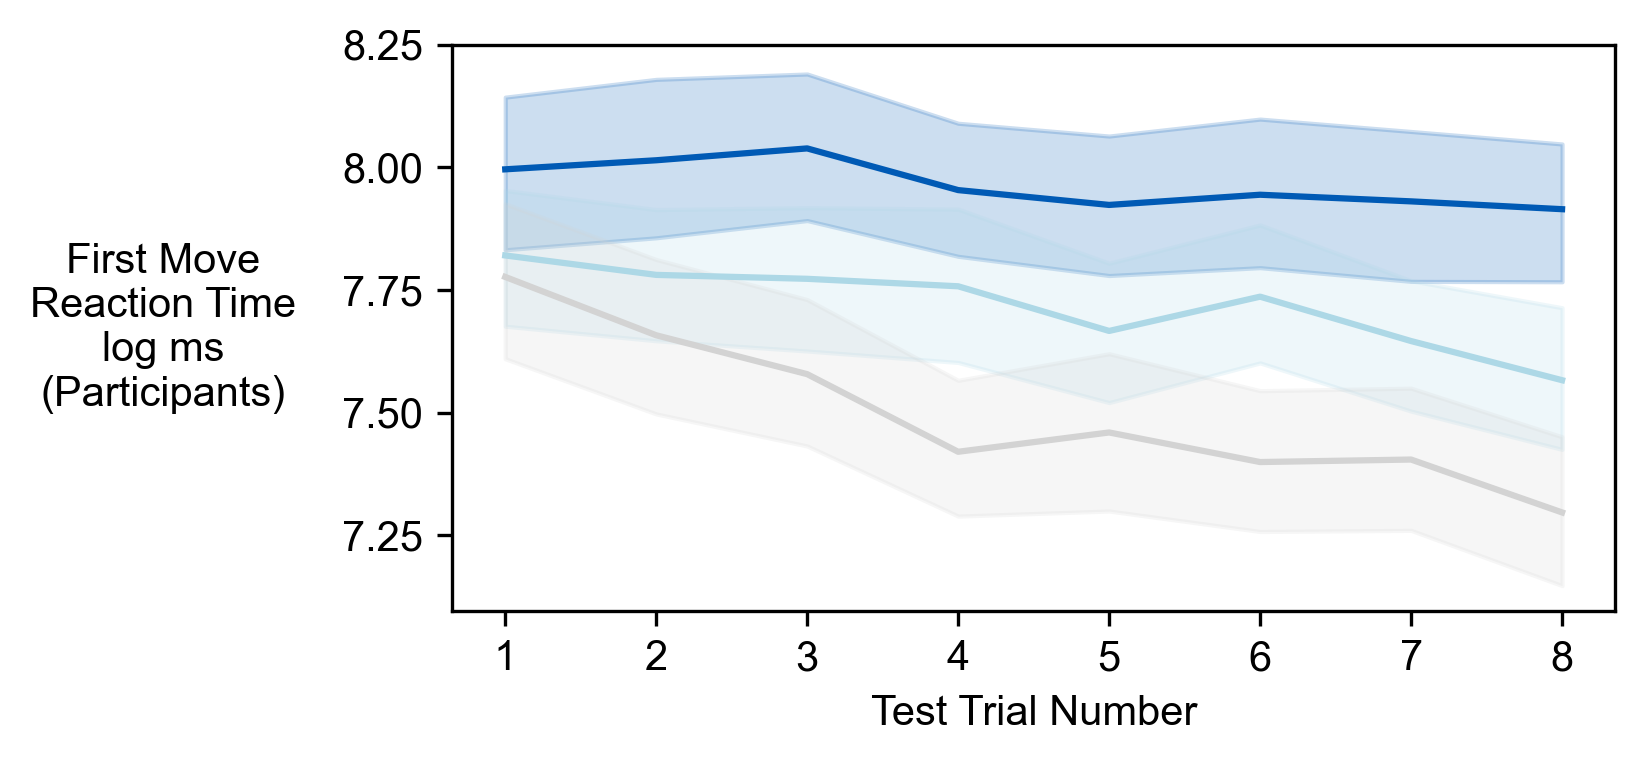

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5), dpi=300)
g = sns.lineplot(
    ax=ax,
    data=test_trials,
    x='test_trial_num',
    y='log_initial_rt_milliseconds',
    hue='condition_name',
    # style="visited_critical_notch",
    hue_order=['ffffffffffff_ffffffff', 'ffffffffffff_bbbbbbbb', 'ffffffffffff_cccccccc'],
    palette=["#005AB5", "lightblue", "lightgrey"],
    ci=95,
)
g.legend_.remove()
ax.set_xlabel("Test Trial Number")
ax.set_ylabel(
    "First Move\nReaction Time\nlog ms\n(Participants)",
    rotation="horizontal",
    labelpad=43,
    va='center'
)
ax.set_yticks([7.25, 7.50, 7.75, 8.0, 8.25])
ax.set_xticks(range(8))
_ = ax.set_xticklabels([str(i) for i in range(1,9)])